# Explore here

In [8]:
# Your code here
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import pickle
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
import os
import numpy as np 

## Carga de Datos

In [9]:
BASE_PATH_PROCESSED= "../data/processed"
BASE_PATH_MODELS = "../models"

def load_data(paths, base_paths):
    """Carga archivos Excel desde múltiples rutas, solo si coinciden con los nombres en 'paths'."""
    dataframes = []
    for path in paths:
        loaded = False
        for base_path in base_paths:
            full_path = os.path.join(base_path, path)
            if os.path.exists(full_path):
                try:
                    dataframes.append(pd.read_excel(full_path))
                    loaded = True
                    break  # Detener la búsqueda si se encuentra el archivo
                except Exception as e:
                    print(f"Error al cargar {full_path}: {e}")
        if not loaded:
            print(f"Archivo no encontrado en ninguna ruta: {path}")
            dataframes.append(None)  # Agregar None para mantener la longitud de la lista

    return dataframes

TRAIN_PATHS = ["X_train_con_outliers.xlsx", "X_train_sin_outliers.xlsx", 'X_train_sel.xlsx']
TEST_PATHS = ["X_test_con_outliers.xlsx", "X_test_sin_outliers.xlsx", 'X_test_sel.xlsx']

# Especificar ambas rutas base para buscar en ambos directorios
BASE_PATHS = [BASE_PATH_PROCESSED, BASE_PATH_MODELS]

TRAIN_DATASETS = load_data(TRAIN_PATHS, BASE_PATHS)
TEST_DATASETS = load_data(TEST_PATHS, BASE_PATHS)

# Cargar y_train y y_test desde BASE_PATH_PROCESSED (asumiendo que están ahí)
y_train = pd.read_excel(os.path.join(BASE_PATH_PROCESSED, "y_train.xlsx"))
y_test = pd.read_excel(os.path.join(BASE_PATH_PROCESSED, "y_test.xlsx"))

## Entreamiento de Datos

In [10]:
# 2. Entrenamiento y Evaluación Inicial
results = []
for index, dataset in enumerate(TRAIN_DATASETS):
    model = DecisionTreeClassifier(random_state=77)
    model.fit(dataset, y_train)
    results.append({
        "train": accuracy_score(y_train, model.predict(dataset)),
        "test": accuracy_score(y_test, model.predict(TEST_DATASETS[index]))
    })
print("Resultados iniciales:", results)

Resultados iniciales: [{'train': 1.0, 'test': 0.7597402597402597}, {'train': 1.0, 'test': 0.7532467532467533}, {'train': 1.0, 'test': 1.0}]


## Optimización de modelo

In [11]:
best_dataset_index = 2
hyperparams = {
    'criterion': ['gini', 'entropy'],  # Menos valores
    'max_depth': [5, 10, 20],  # Menos valores
    'min_samples_split': [2, 5, 10],  # Menos valores
    'min_samples_leaf': [1, 2, 5],  # Menos valores
    'max_features': ['sqrt', 'log2'],  # Menos valores
    'max_leaf_nodes': [10, 20, 50],  # Menos valores
    'ccp_alpha': [0.0, 0.01, 0.1]  # Menos valores
}

# Usar RandomizedSearchCV en lugar de GridSearchCV
grid = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=77),
    hyperparams,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    scoring="accuracy",
    cv=3,  # Menos folds de validación cruzada
    n_jobs=-1,  # Usar todos los núcleos de la CPU
    random_state=77
)

grid.fit(TRAIN_DATASETS[best_dataset_index], y_train)
final_model = grid.best_estimator_
print("Mejores hiperparámetros:", grid.best_estimator_)

Mejores hiperparámetros: DecisionTreeClassifier(max_depth=10, max_features='log2', max_leaf_nodes=50,
                       min_samples_split=5, random_state=77)


## Evaluación Modelo Opt

In [12]:
print("Score train:", accuracy_score(y_train, final_model.predict(TRAIN_DATASETS[best_dataset_index])))
print("Score test:", accuracy_score(y_test, final_model.predict(TEST_DATASETS[best_dataset_index])))

Score train: 0.996742671009772
Score test: 0.974025974025974


## Visualización de Árbol de Desición

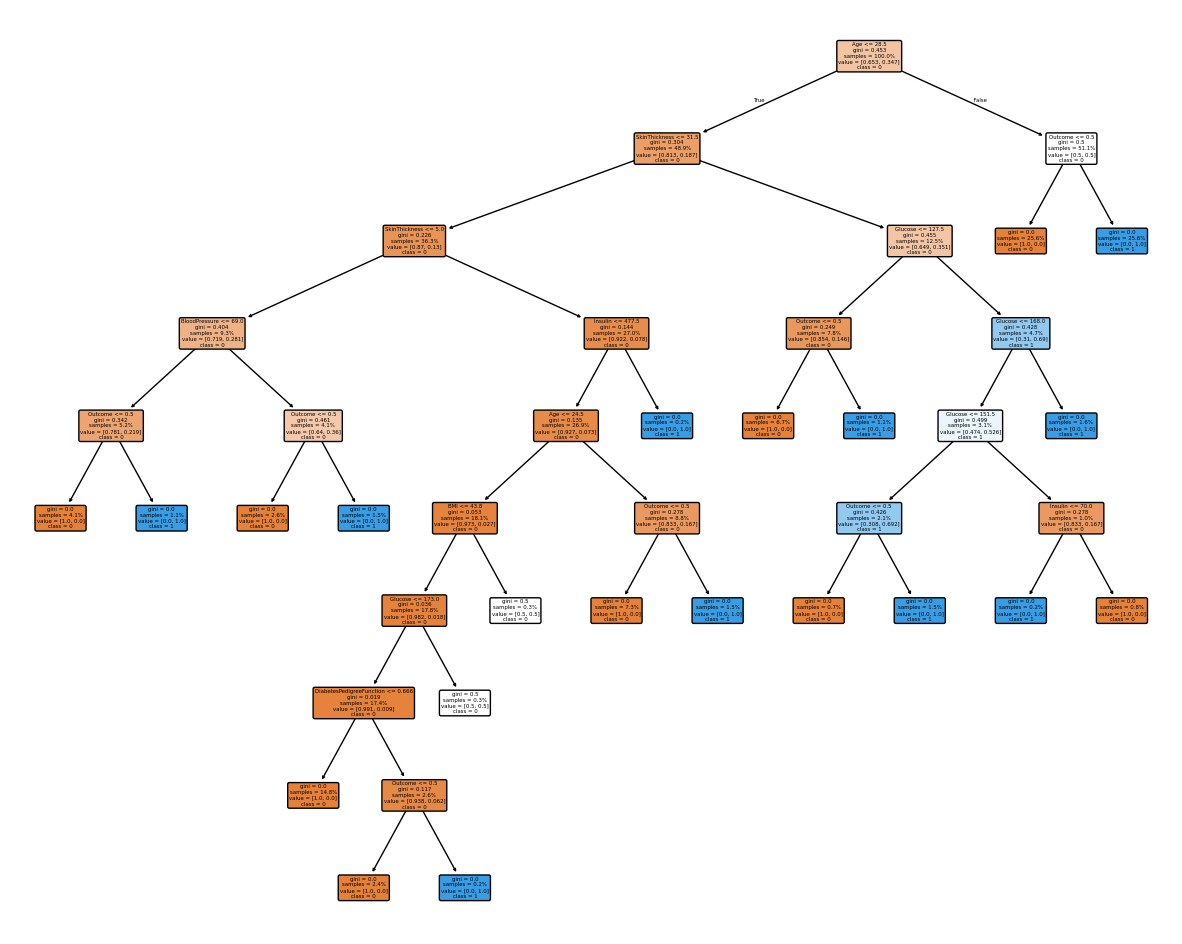

In [13]:
plt.figure(figsize=(15, 12))
plot_tree(final_model, filled=True, feature_names=TRAIN_DATASETS[best_dataset_index].columns.tolist(), class_names=['0', '1'], rounded=True, proportion=True)
plt.show()

## Se guarda el modelo

In [14]:
with open("../models/Decision_tree_model.sav", "wb") as file:
    pickle.dump(final_model, file)